# Struttura dei test

Per la fase di test sono stati generati dei dataset tramite la funzione
`make_classification` del modulo `scikit-learn` e l'algoritmo genetico è stato
eseguito su un totale di 10 punti per dataset. I parametri che variano da un
dataset all'altro sono al momento:

- **Numero di feature di ogni punto**: 2, 4, 8, 16, 32 e 64.
- **Seme di casualità per il generatore**: 0, 1.

Per i test effettuati sono stati presi in considerazione tre modelli differenti
del modulo `scikit-learn`: `RandomForestClassifier`, `SVC` e `MLPClassifier`.
Su ognuno dei dataset è stato eseguito l'algoritmo genetico usando tutti e tre
i modelli e, per ognuno di essi, popolazioni sintetiche da 1000, 2000, 4000,
8000 e 16000 individui.

## Dataset dei risultati

Ogni riga del dataset contiene:

- **Informazioni sul dataset**:
  - **samples**: numero di punti, per ciascun dataset, su cui è stato eseguito
    l'algoritmo genetico.
  - **features**: numero di feature dei punti nel dataset.
  - **classes**: numero di classi possibili per un determinato dataset.
  - **clusters**: numero di cluster per classe.
  - **seed**: seme di casualità con cui è stato generato il dataset.
- **Parametri algoritmo genetico**:
  - **population_size**: numero di individui sintetici generati.
  - **point**: ID del punto del dataset da cui vengono generati i dati
    sintetici.
  - **class**: classe del punto.
  - **target**: classe target dell'algoritmo genetico.
  - **model**: il modello utilizzato per la classificazione.
- **Risultati**:
  - **min/mean/max_fitness**: valori minimo, medio e massimo di fitness, della
    popolazione generata dall'algoritmo genetico.
  - **fitness_std**: deviazione standard dei valori di fitness della popolazione
    sintetica finale.
  - **accuracy**: valore di _precisione_ dell'algoritmo genetico. Si tratta
    della percentuale di individui sintetici classificati nella classe target.

Possiamo quindi vedere ogni riga come una singola esecuzione dell'algoritmo
genetico su uno specifico punto, di uno specifico dataset e con una specifica
classe target.

## Conversione fitness-distanza

Dato che i valori di fitness non sono altro che la distanza di ogni punto
sintetico dal punto di riferimento, moltiplicata per un peso di $-1$, possiamo
convertire le tre colonne di fitness in valori di distanza moltiplicandole
per $-1$ di modo da avere valori positivi interpretabili.

Ovviamente ciò che era considerato un valore di fitness minimo, diventerà
un valore di distanza massimo (stesso discorso per i valori di fitness massimi).


In [1]:
import pandas as pd

ppga_df = pd.read_csv("../results/quality/ppga.csv")
ppga_df

,samples,features,classes,clusters,seed,population_size,point,class,target,model,max_distance,mean_distance,distance_std,min_distance,accuracy
0,10,2,2,1,0,1000,0,1,0,MLPClassifier,0.653946,0.650508,0.001370,0.647965,1.0
1,10,2,2,1,0,1000,0,1,1,MLPClassifier,0.020127,0.010692,0.005472,0.000060,1.0
2,10,2,2,1,0,1000,1,0,0,MLPClassifier,0.018579,0.009630,0.005163,0.000290,1.0
3,10,2,2,1,0,1000,1,0,1,MLPClassifier,2.313962,2.303711,0.005538,2.292529,1.0
4,10,2,2,1,0,1000,2,0,0,MLPClassifier,0.019015,0.009669,0.005400,0.000484,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,10,64,2,1,1,16000,7,0,1,SVC,18.034405,17.892124,0.087346,17.630542,1.0
3596,10,64,2,1,1,16000,8,0,0,SVC,0.600466,0.382312,0.148695,0.005404,1.0
3597,10,64,2,1,1,16000,8,0,1,SVC,17.296355,16.725999,0.566120,15.312778,1.0
3598,10,64,2,1,1,16000,9,1,0,SVC,15.960198,15.937814,0.018706,15.844560,1.0


In [2]:
deap_df = pd.read_csv("../results/quality/deap.csv")
deap_df

,samples,features,classes,clusters,seed,population_size,point,class,target,model,max_distance,mean_distance,distance_std,min_distance,accuracy
0,10,2,2,1,0,1000,0,1,0,MLPClassifier,0.655846,0.655428,0.000312,0.654315,1.0
1,10,2,2,1,0,1000,0,1,1,MLPClassifier,0.015760,0.008168,0.004951,0.000209,1.0
2,10,2,2,1,0,1000,1,0,0,MLPClassifier,0.022120,0.010876,0.006188,0.000391,1.0
3,10,2,2,1,0,1000,1,0,1,MLPClassifier,2.287023,2.282767,0.002259,2.279045,1.0
4,10,2,2,1,0,1000,2,0,0,MLPClassifier,0.014619,0.006117,0.003961,0.000538,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3595,10,64,2,1,1,16000,7,0,1,SVC,19.955289,19.671390,0.231801,18.908130,1.0
3596,10,64,2,1,1,16000,8,0,0,SVC,1.689840,0.937734,0.455527,0.014578,1.0
3597,10,64,2,1,1,16000,8,0,1,SVC,11.423356,11.265149,0.114972,10.905789,1.0
3598,10,64,2,1,1,16000,9,1,0,SVC,15.580845,15.461501,0.097153,15.115339,1.0


# Correttezza

Prima di tutto si è verificato che tutti i test, per entrambe le librerie,
abbiano generato punti sintetici classificati correttamente, andando a
controllare che il valore di `accuracy` sia sempre uguale a $1$.


In [3]:
print(f"Accuracy below 1.0 for PPGA: {len(ppga_df[ppga_df['accuracy'] != 1.0])}")
print(f"Accuracy below 1.0 for DEAP: {len(deap_df[deap_df['accuracy'] != 1.0])}")

Accuracy below 1.0 for PPGA: 0
Accuracy below 1.0 for DEAP: 0


# Fitness

Iniziamo con il contare il numero di volte in cui una libreria ha prodotto
risultati migliori dell'altra in percentuale (sui singoli punti e loro
risultati).


In [4]:
mask = ppga_df["mean_distance"] < deap_df["mean_distance"]
mask2 = ppga_df["mean_distance"] > deap_df["mean_distance"]

better_ppga = ppga_df[mask]
better_deap = deap_df[mask2]

print(f"PPGA better than DEAP: {len(better_ppga) / len(ppga_df) * 100.0:.2f}% of times")
print(f"DEAP better than PPGA: {len(better_deap) / len(deap_df) * 100.0:.2f}% of times")

PPGA better than DEAP: 62.67% of times
DEAP better than PPGA: 37.28% of times


Valutiamo l'entità del miglioramento in entrambi i casi considerando solo il
valor medio di fitness, prima per PPGA poi per DEAP.


In [5]:
mean_distance_diff = (
    (deap_df[mask]["mean_distance"] - ppga_df[mask]["mean_distance"])
    / deap_df[mask]["mean_distance"]
    * 100.0
)

print("PPGA")
print(f"min mean distance: {mean_distance_diff.min():.4f}%")
print(f"mean mean distance: {mean_distance_diff.mean():.4f}%")
print(f"max mean distance: {mean_distance_diff.max():.4f}%")

mean_distance_diff = (
    (ppga_df[mask2]["mean_distance"] - deap_df[mask2]["mean_distance"])
    / ppga_df[mask2]["mean_distance"]
    * 100.0
)

print("\nDEAP")
print(f"min mean distance: {mean_distance_diff.min():.4f}%")
print(f"mean mean distance: {mean_distance_diff.mean():.4f}%")
print(f"max mean distance: {mean_distance_diff.max():.4f}%")

PPGA
min mean distance: 0.0028%
mean mean distance: 33.0630%
max mean distance: 93.1545%

DEAP
min mean distance: 0.0102%
mean mean distance: 18.2321%
max mean distance: 84.8844%


Per un confronto più generale si sono sommati tutti i valori di distanza
ottenuti per poi confrontare due singoli valori.


In [6]:
ppga_sum = ppga_df["mean_distance"].sum()
deap_sum = deap_df["mean_distance"].sum()

print(f"PPGA total score: {ppga_sum:.4f}")
print(f"DEAP total score: {deap_sum:.4f}")

improvement = (deap_sum - ppga_sum) / deap_sum * 100.0

print(f"PPGA total improvement over DEAP: {improvement:.2f}%")

PPGA total score: 7801.7303
DEAP total score: 8839.5879
PPGA total improvement over DEAP: 11.74%


Di seguito rappresentazioni grafiche delle distribuzioni dei valori di distanza
ottenuti con le due librerie. Sulla sinistra le esecuzioni dell'algoritmo
genetico con classe target uguale alla classe del punto di riferimento e sulla
quelle con classe target differente.


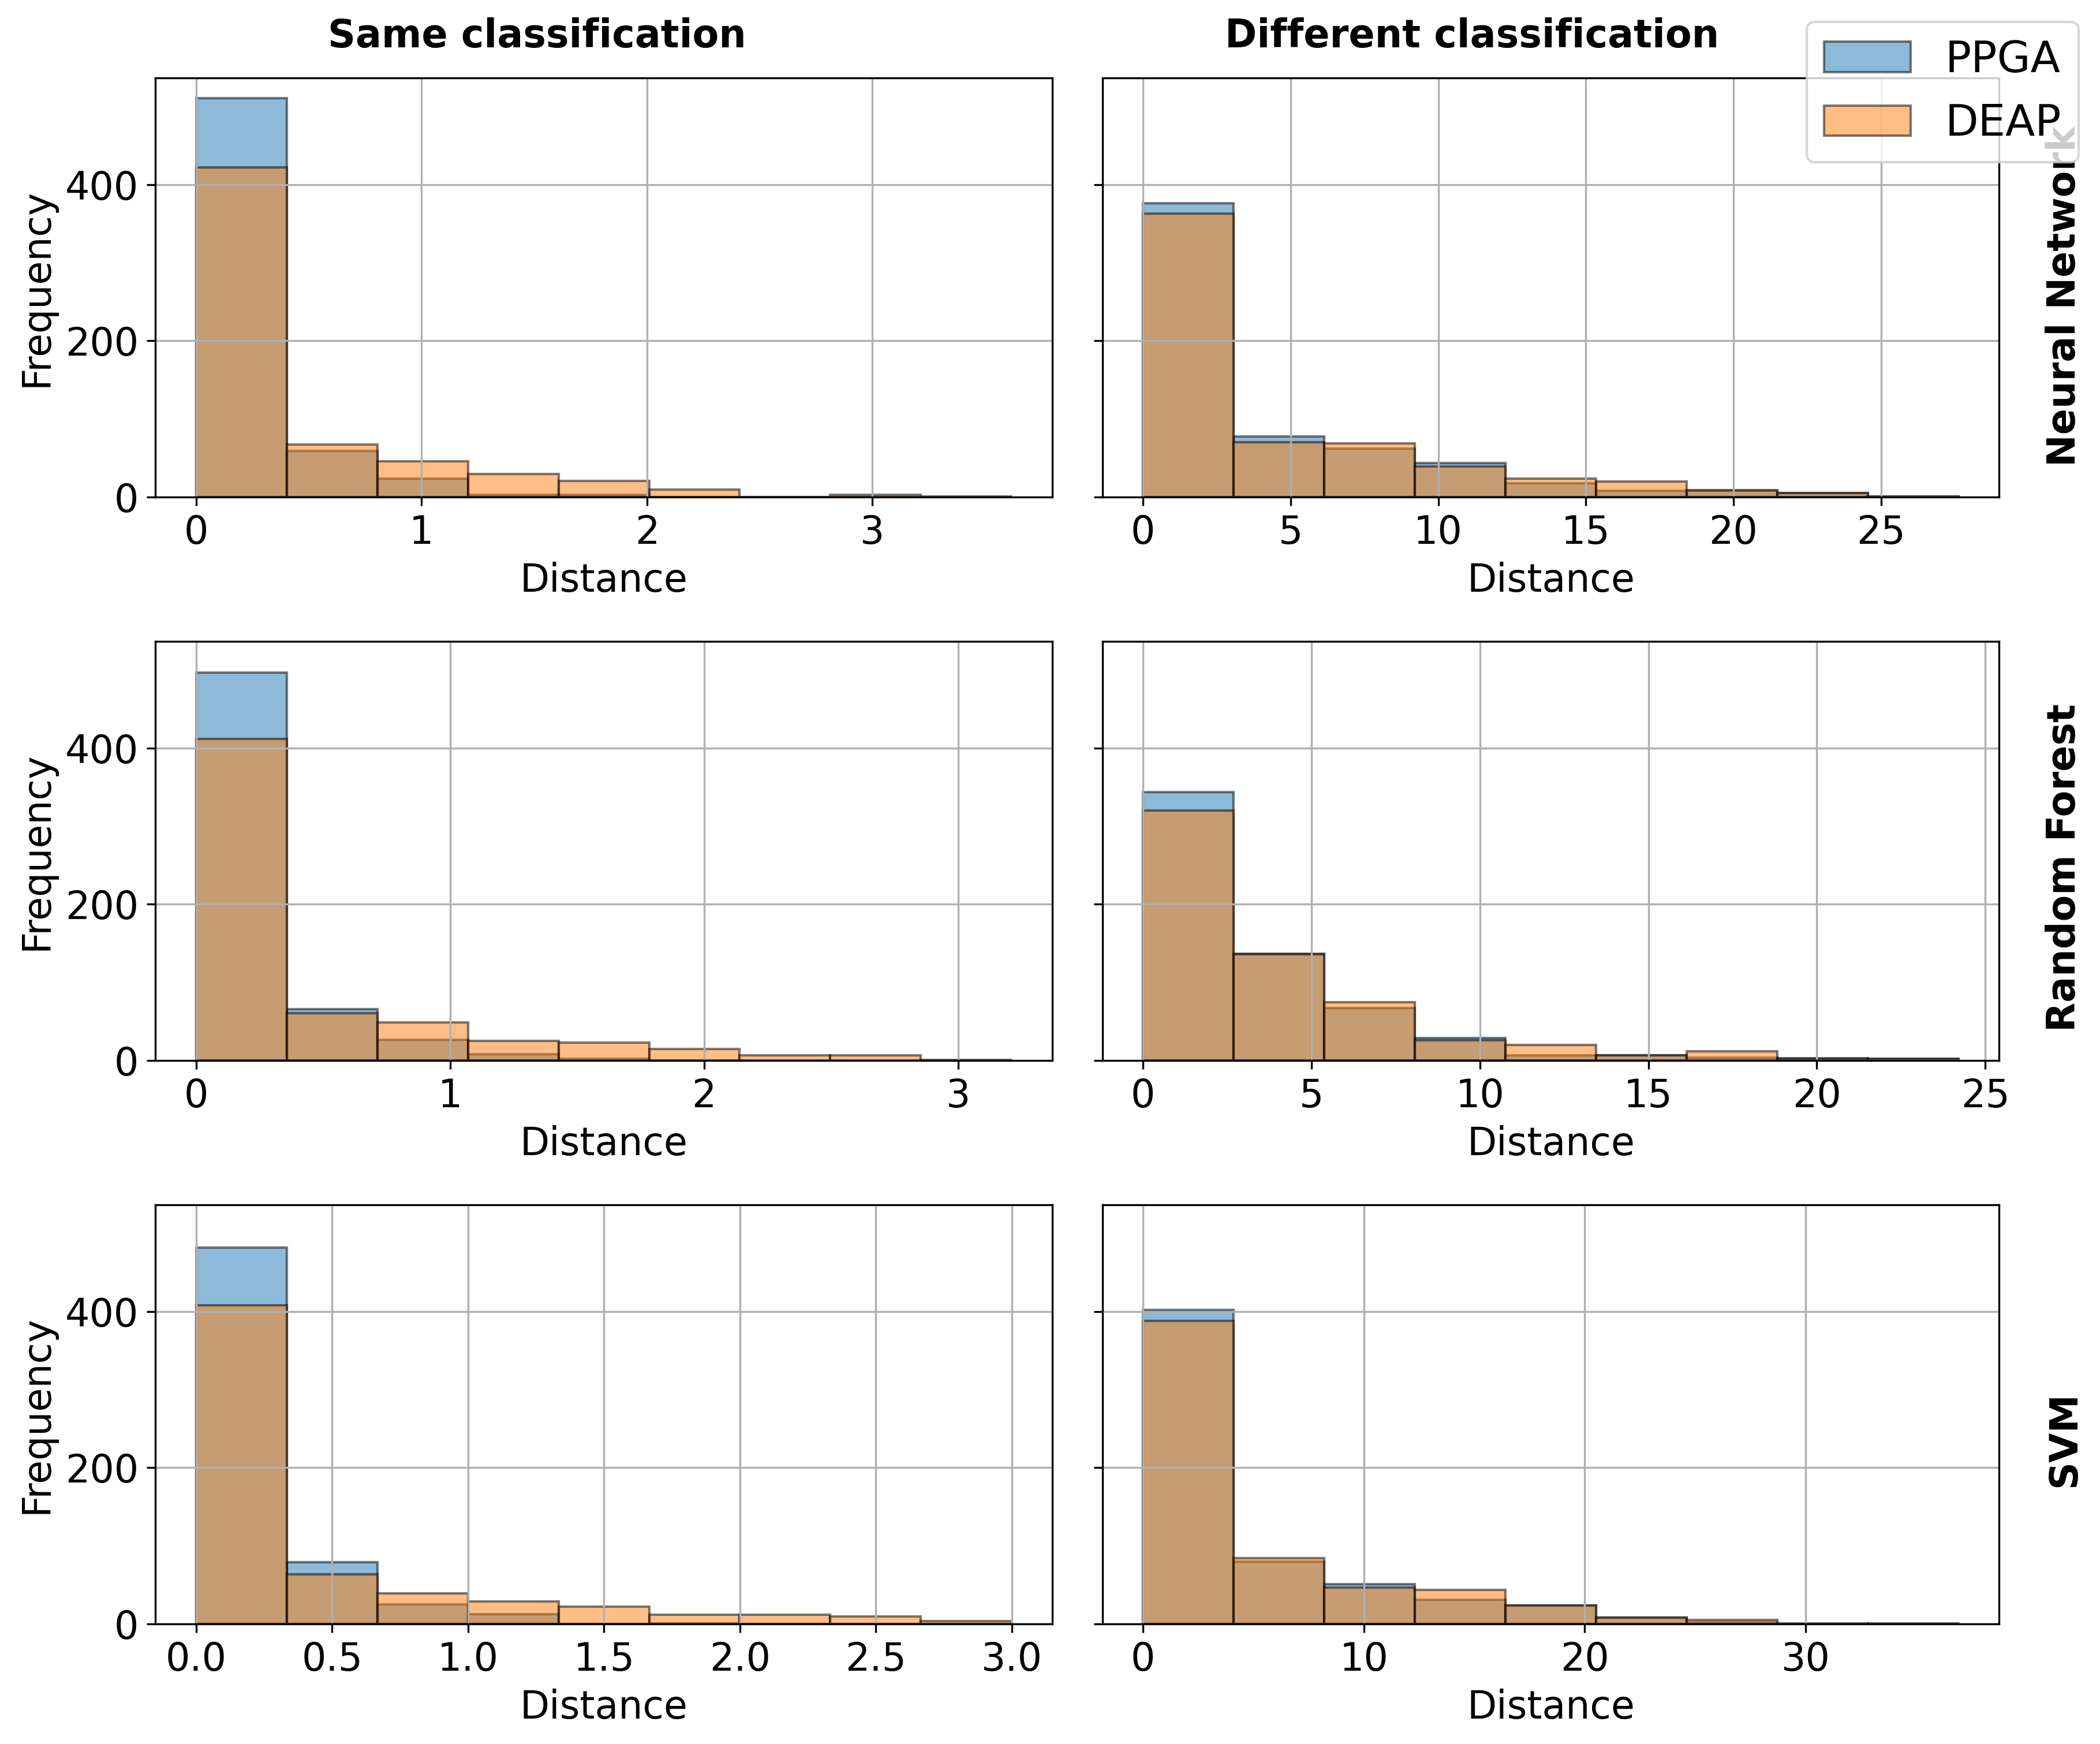

In [36]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import numpy as np

matplotlib.rcParams.update({"font.size": 16})


def plot_distance_distribution(df1: pd.DataFrame, df2: pd.DataFrame):
    models = ppga_df["model"].unique()

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(12, 10), dpi=300)
    bins_num = 10

    col_titles = ["Same classification", "Different classification"]
    for j, title in enumerate(col_titles):
        fig.text(
            0.27 + j * 0.45,
            1,
            title,
            ha="center",
            va="center",
            fontsize="16",
            fontweight="bold",
        )

    row_titles = ["Neural Network", "Random Forest", "SVM"]
    for i, model in enumerate(models):
        fig.text(
            1.005,
            0.85 - i * 0.33,
            row_titles[i],
            ha="center",
            va="center",
            fontsize=16,
            fontweight="bold",
            rotation=90,
        )

        # same classification
        mask = (ppga_df["model"] == model) & (ppga_df["class"] == ppga_df["target"])
        ppga_dist = ppga_df[mask]["mean_distance"].to_numpy()

        mask = (deap_df["model"] == model) & (deap_df["class"] == deap_df["target"])
        deap_dist = deap_df[mask]["mean_distance"].to_numpy()

        # axes[i][0].set_title(f"{model}")
        axes[i][0].set_xlabel("Distance")
        axes[i][0].set_ylabel("Frequency")
        bins = np.linspace(0, max(np.max(ppga_dist), np.max(deap_dist)), bins_num)
        axes[i][0].hist(
            ppga_dist,
            bins=bins,
            edgecolor="black",
            alpha=0.5,
            label="PPGA",
        )
        axes[i][0].hist(
            deap_dist,
            bins=bins,
            edgecolor="black",
            alpha=0.5,
            label="DEAP",
        )
        # axes[i][0].legend()
        axes[i][0].grid(True)

        # different classification
        mask = (ppga_df["model"] == model) & (ppga_df["class"] != ppga_df["target"])
        ppga_dist = ppga_df[mask]["mean_distance"].to_numpy()

        mask = (deap_df["model"] == model) & (deap_df["class"] != deap_df["target"])
        deap_dist = deap_df[mask]["mean_distance"].to_numpy()

        # axes[i][1].set_title(f"{model}")
        axes[i][1].set_xlabel("Distance")
        # axes[i][1].set_ylabel("Frequency")

        bins = np.linspace(0, max(np.max(ppga_dist), np.max(deap_dist)), bins_num)
        axes[i][1].hist(
            ppga_dist,
            bins=bins,
            edgecolor="black",
            alpha=0.5,
            label="PPGA",
        )

        axes[i][1].hist(
            deap_dist,
            bins=bins,
            edgecolor="black",
            alpha=0.5,
            label="DEAP",
        )
        # axes[i][1].legend()
        axes[i][1].grid(True)

    colors = plt.get_cmap("tab10").colors[:2]
    custom_legend = [
        Patch(facecolor=colors[0], edgecolor="black", alpha=0.5, label="PPGA"),
        Patch(facecolor=colors[1], edgecolor="black", alpha=0.5, label="DEAP"),
    ]

    fig.legend(handles=custom_legend, loc="upper right", fontsize=18)
    plt.tight_layout()
    plt.savefig("/home/federico/tesi/immagini/hist.svg")
    plt.show()


plot_distance_distribution(ppga_df, deap_df)

Il problema dell'analisi appena fatta è che non confronta direttamente la
qualità delle soluzioni sulle singole simulazioni. Nel complessi potremmo avere
valori di distanza simili, ma non è detto che questi siano simili quando si
lavora su un input fissato.

Per un'analisi di questo tipo sono stati ordinati in modo crescente tutti i
valori di distanza media ottenuti con DEAP tramite la funzione `argsort` di
Numpy, per poi usare gli indici generati per ordinare i valori di distanza
ottenuti con PPGA.

Sono stati quindi disposti in ordine crescente i valori di distanza di DEAP e
sulla stessa coordinata $x$ sono stati aggiunti i corrispondenti valori di
distanza calcolato con PPGA sullo stesso input. In questo modo è possibile
confrontare il valor medio di distanza ottenuto per ogni esecuzione.

Dato che però i punti singoli sono molti e il grafico risulterebbe poco
informativo si è suddiviso il vettore di valori in blocchi di 15 elementi di
cui si è preso il valor medio.


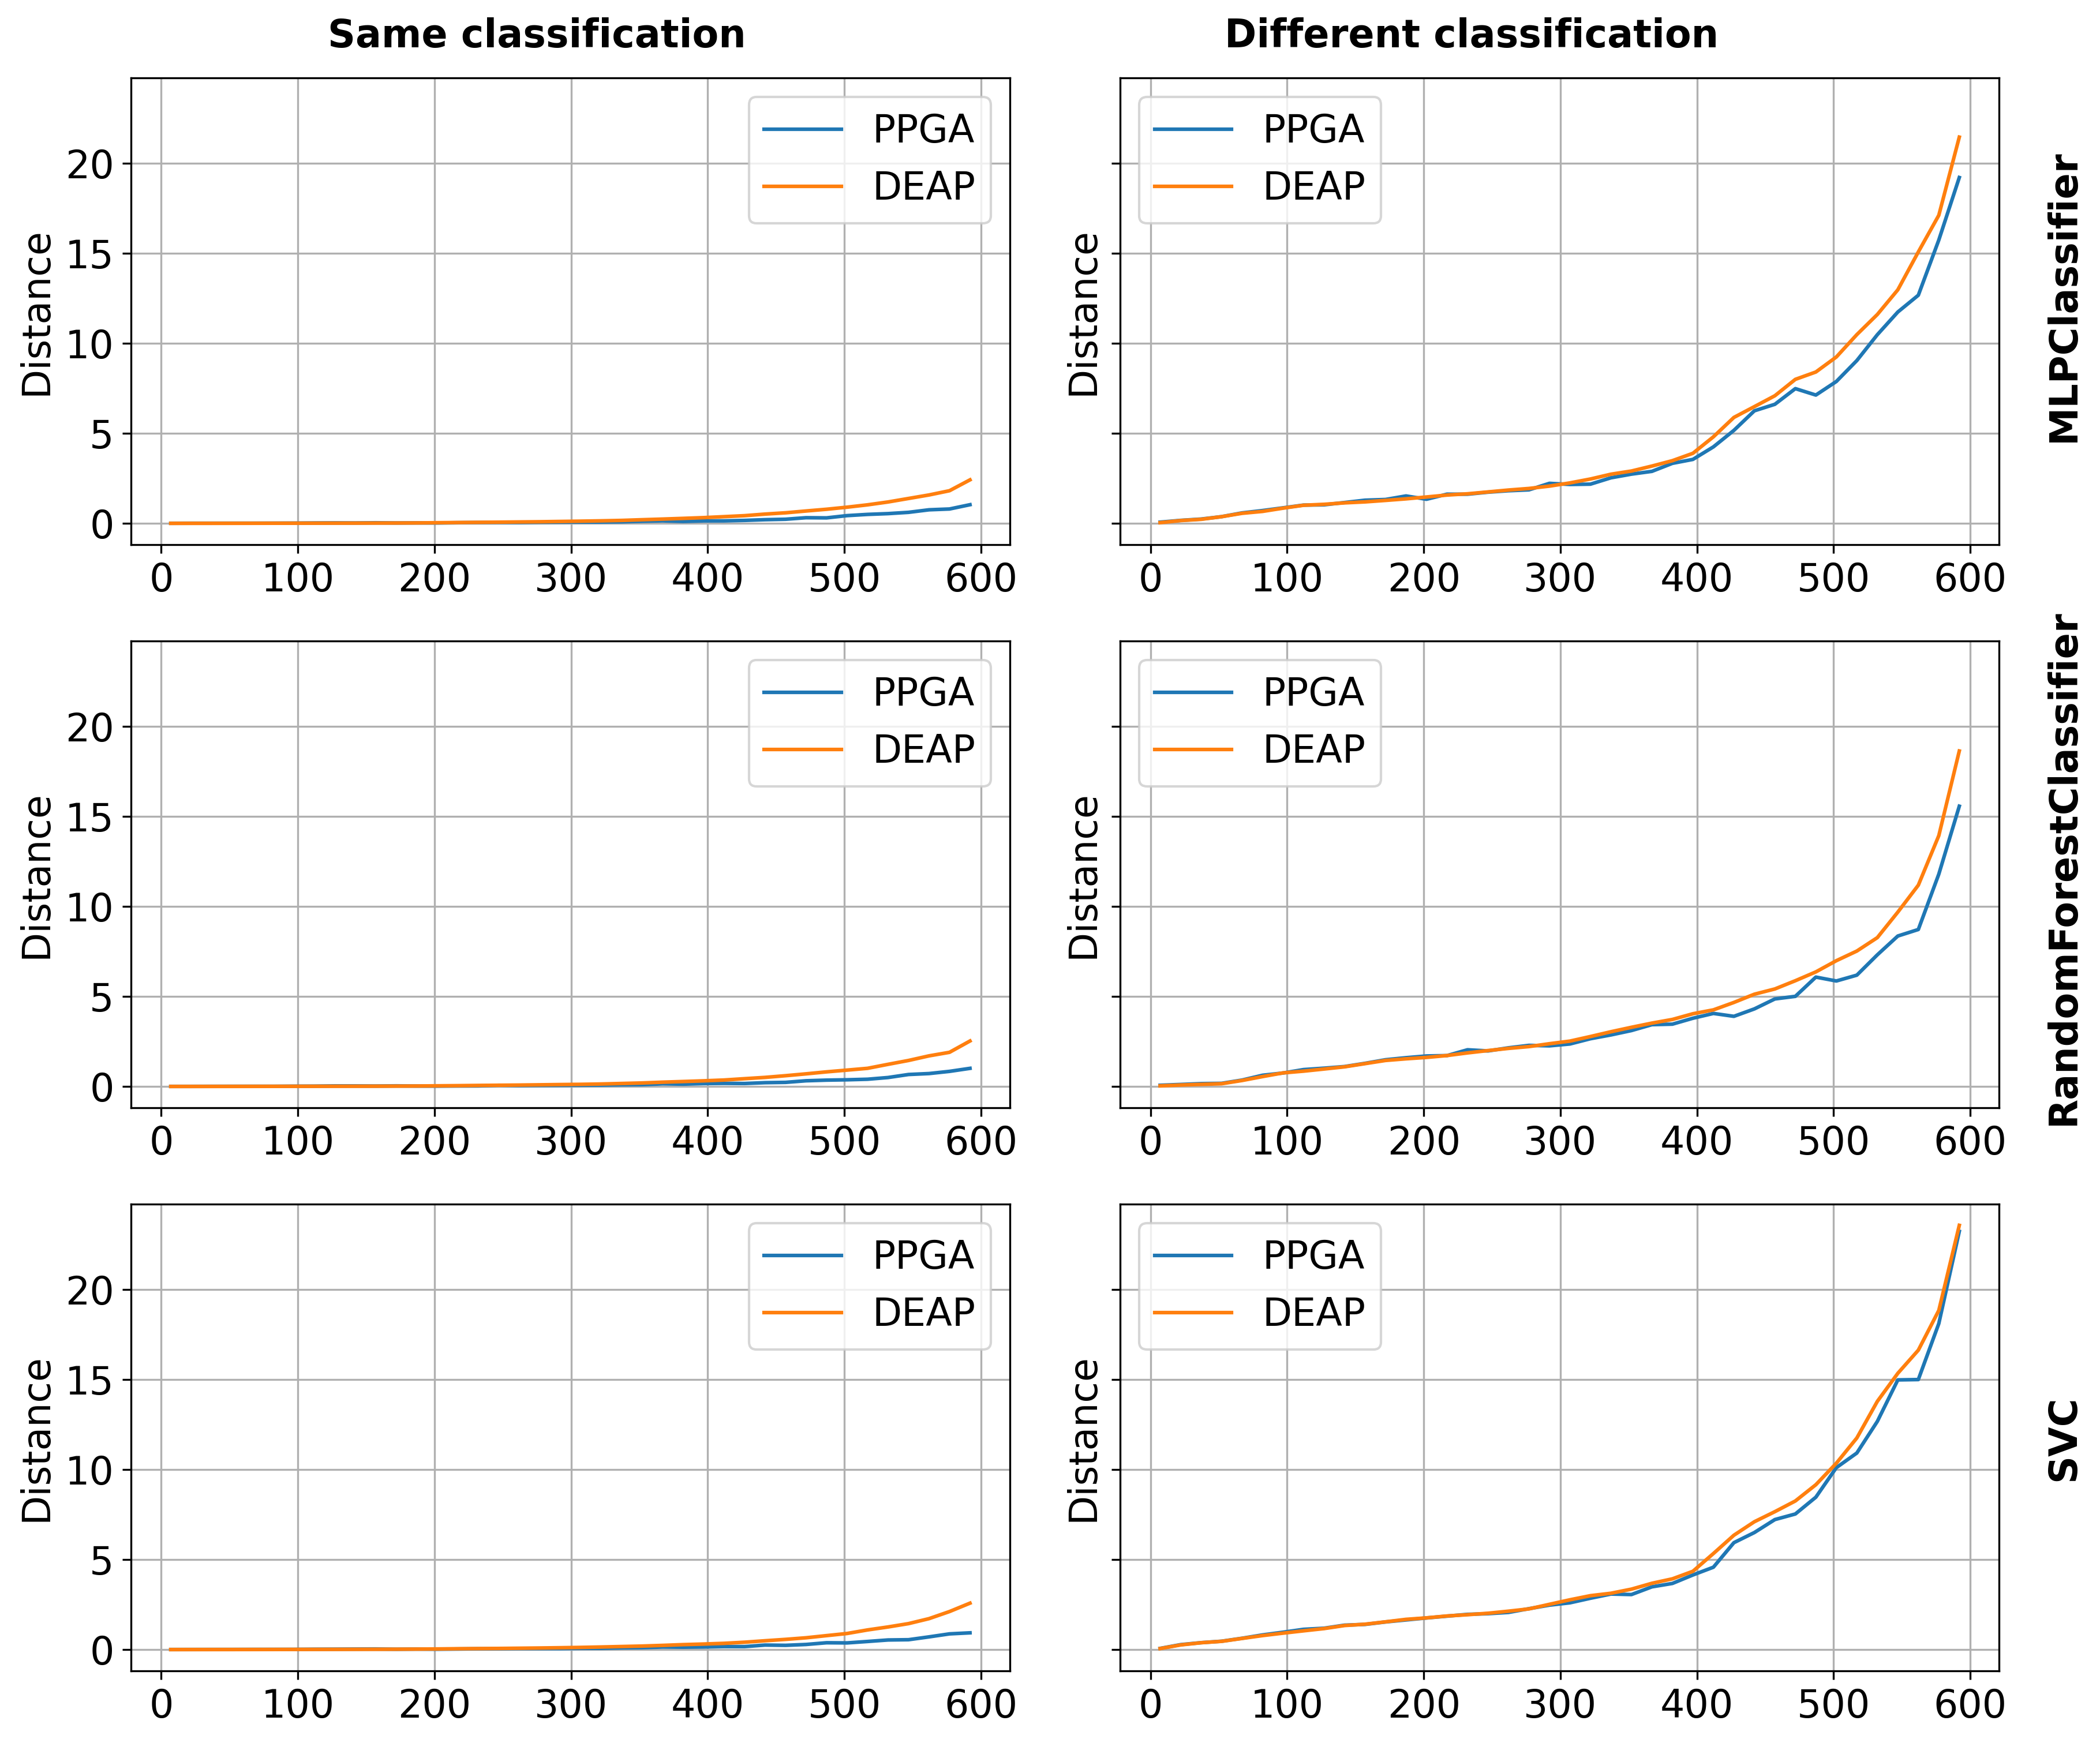

In [8]:
def plot_distance_trend(df1: pd.DataFrame, df2: pd.DataFrame):
    models = ppga_df["model"].unique()

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(12, 10), dpi=300)

    def make_chunk(a: np.ndarray, chunk_size: int):
        return a[: len(a) - len(a) % chunk_size].reshape(-1, chunk_size).mean(axis=1)

    col_titles = ["Same classification", "Different classification"]
    for j, title in enumerate(col_titles):
        fig.text(
            0.27 + j * 0.45,
            1,
            title,
            ha="center",
            va="center",
            fontsize="16",
            fontweight="bold",
        )

    for i, model in enumerate(models):
        fig.text(
            1.005,
            0.85 - i * 0.33,
            model,
            ha="center",
            va="center",
            fontsize=16,
            fontweight="bold",
            rotation=90,
        )
        # Same classification
        # DEAP
        mask = (deap_df["model"] == model) & (deap_df["class"] == deap_df["target"])
        deap_dist = deap_df[mask]["mean_distance"].to_numpy()
        indices = np.argsort(deap_dist)
        deap_dist = deap_dist[indices]

        # PPGA
        mask = (ppga_df["model"] == model) & (ppga_df["class"] == ppga_df["target"])
        ppga_dist = ppga_df[mask]["mean_distance"].to_numpy()
        ppga_dist = ppga_dist[indices]

        chunk_size = 15
        x = make_chunk(np.array([i for i in range(len(deap_dist))]), chunk_size)
        deap_dist = make_chunk(deap_dist, chunk_size)
        ppga_dist = make_chunk(ppga_dist, chunk_size)

        # axes[i][0].set_title(f"{model} mean distance\nSame classification")
        axes[i][0].set_ylabel("Distance")
        axes[i][0].plot(x, ppga_dist, label="PPGA")
        axes[i][0].plot(x, deap_dist, label="DEAP")
        axes[i][0].legend()
        axes[i][0].grid(True)

        # Different classification
        # DEAP
        mask = (deap_df["model"] == model) & (deap_df["class"] != deap_df["target"])
        deap_dist = deap_df[mask]["mean_distance"].to_numpy()
        indices = np.argsort(deap_dist)
        deap_dist = deap_dist[indices]

        # PPGA
        mask = (ppga_df["model"] == model) & (ppga_df["class"] != ppga_df["target"])
        ppga_dist = ppga_df[mask]["mean_distance"].to_numpy()
        ppga_dist = ppga_dist[indices]

        x = make_chunk(np.array([i for i in range(len(deap_dist))]), chunk_size)
        deap_dist = make_chunk(deap_dist, chunk_size)
        ppga_dist = make_chunk(ppga_dist, chunk_size)

        # axes[i][1].set_title(f"{model} mean distance\nDifferent classification")
        axes[i][1].set_ylabel("Distance")
        axes[i][1].plot(x, ppga_dist, label="PPGA")
        axes[i][1].plot(x, deap_dist, label="DEAP")
        axes[i][1].legend()
        axes[i][1].grid(True)

    plt.tight_layout()
    plt.savefig("/home/federico/tesi/immagini/dist.svg")
    plt.show()


plot_distance_trend(ppga_df, deap_df)

Si è poi ricavata la distribuzione delle differenze tra le due librerie e si è
calcolato quanti di questi valori superano la deviazione standard della stessa.


Same classification difference mean: 0.245868
Same classification difference std: 0.468827
Same class greater than std: 6.67%
Different classification difference mean: 0.637334
Different classification difference std: 1.163104
Different class greater than std: 6.94%


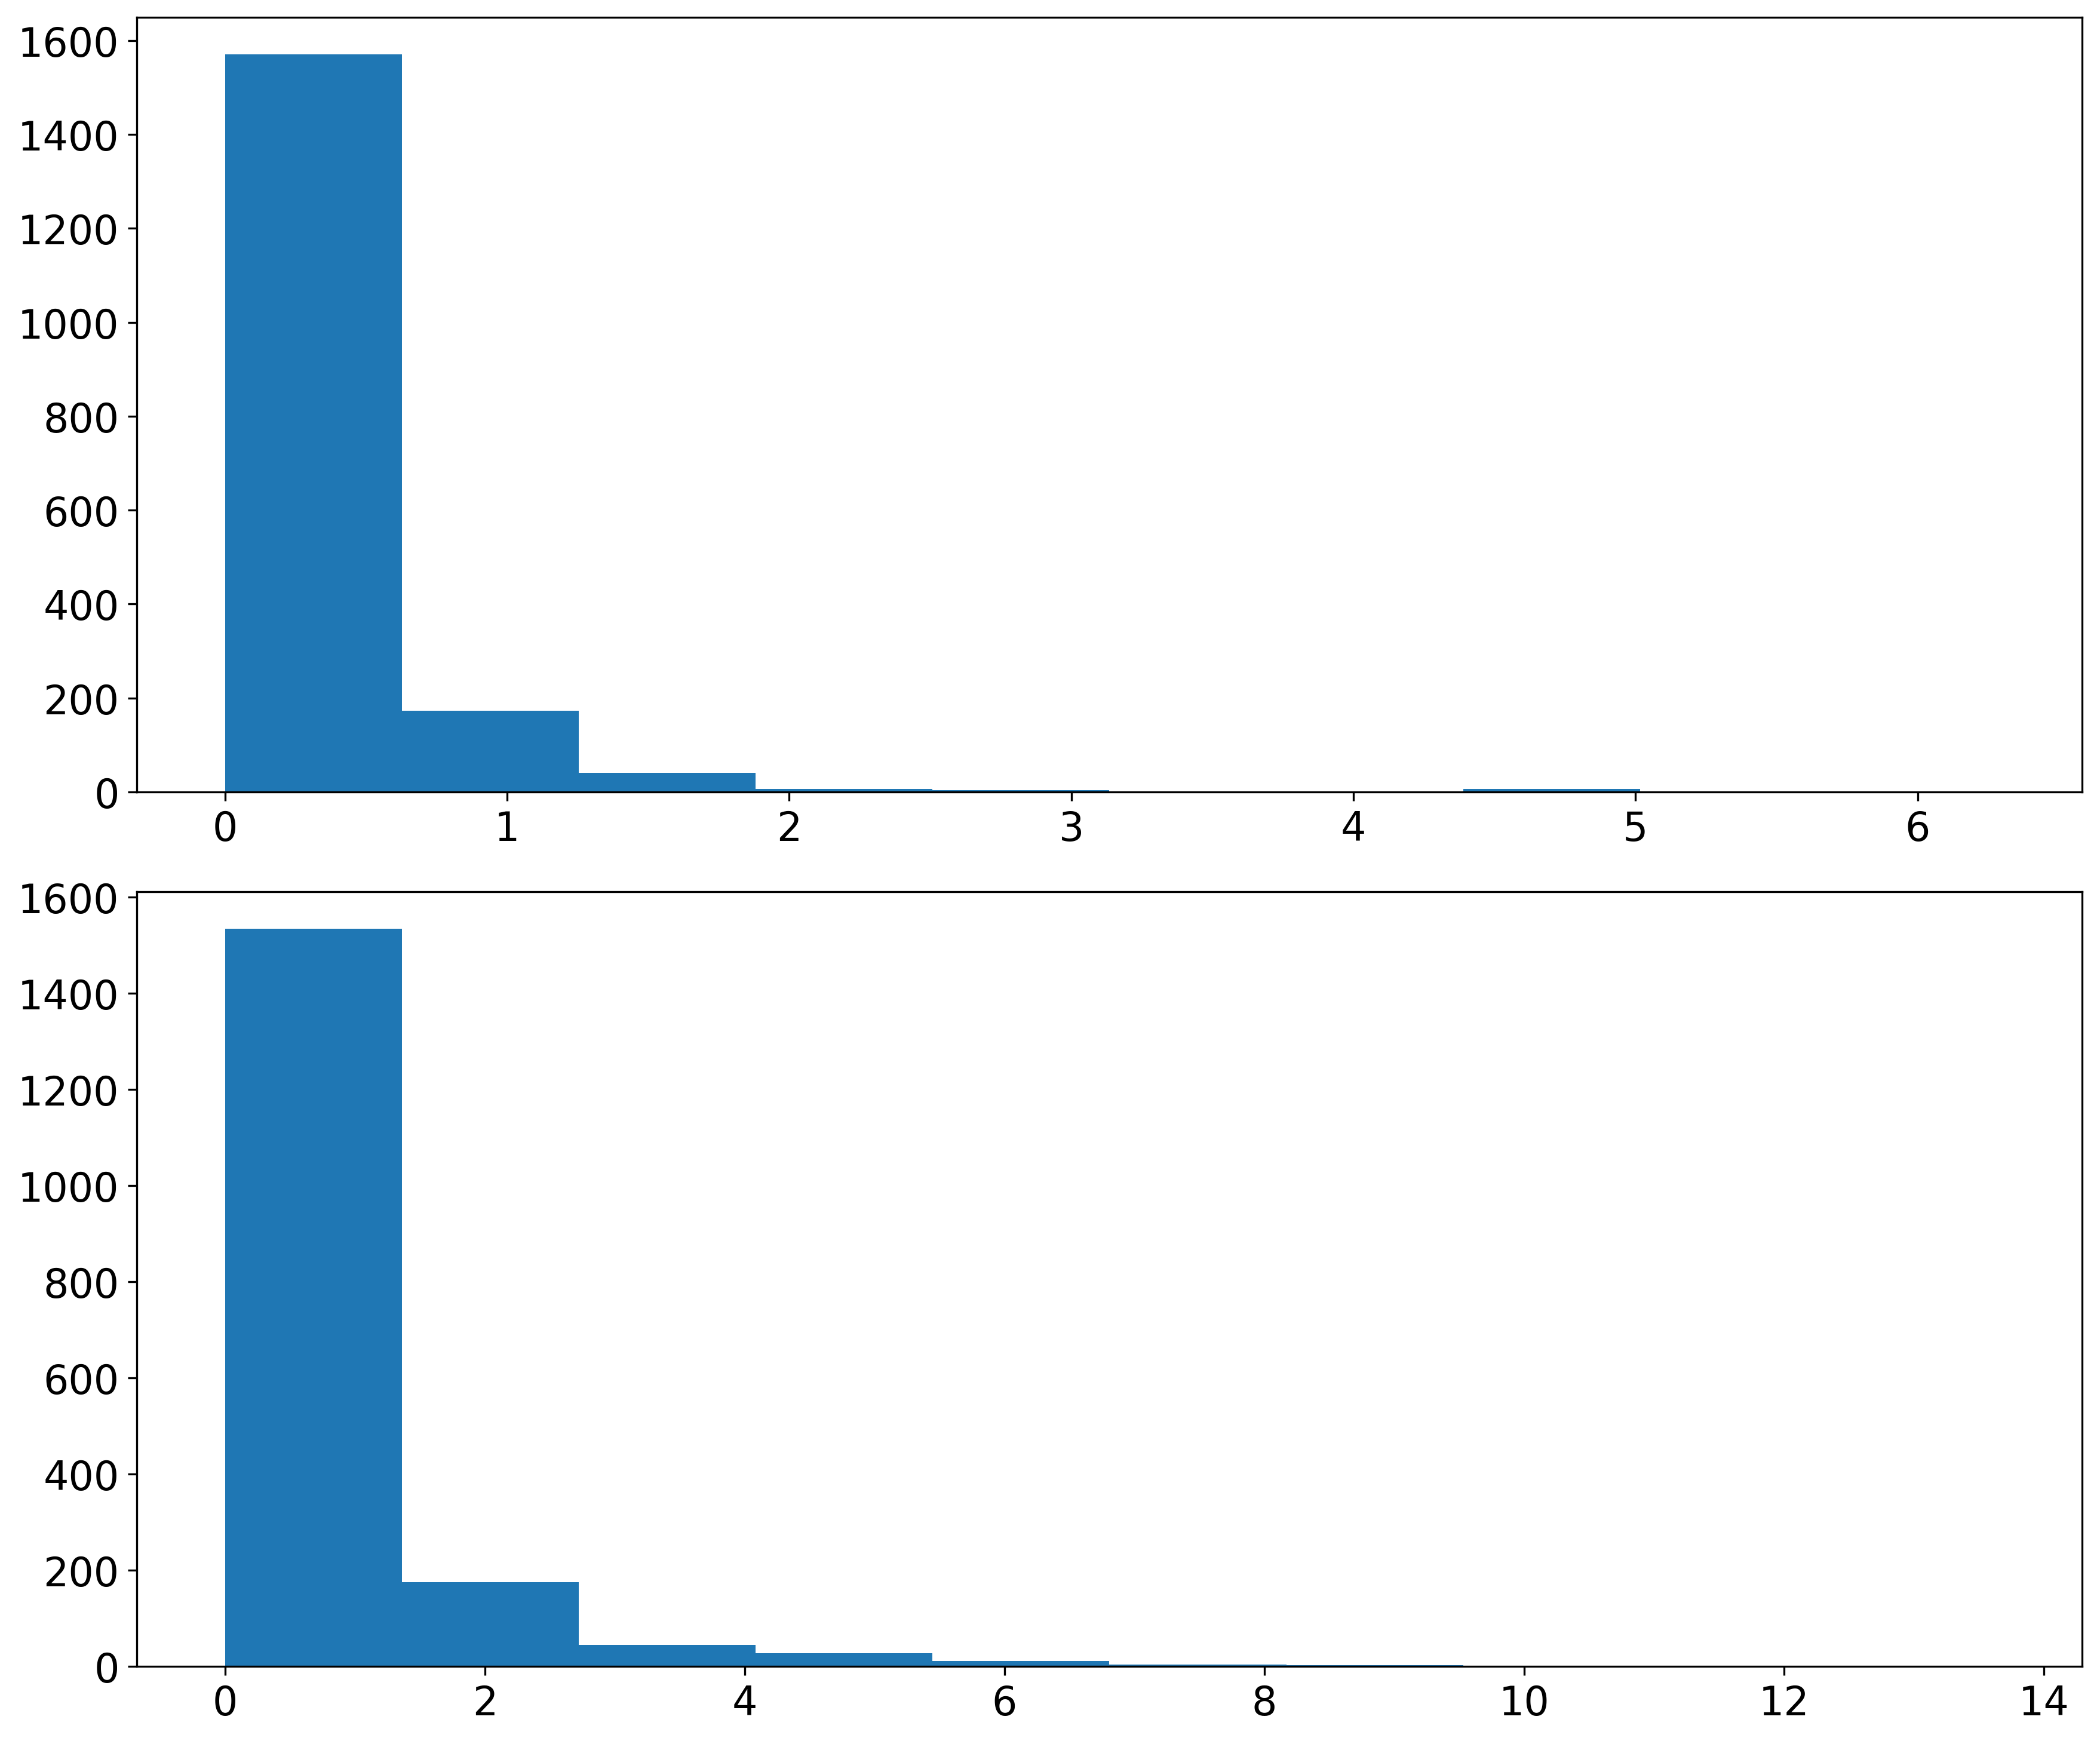

In [9]:
models = ppga_df["model"].unique()

# fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(12, 10), dpi=300)
fig, axes = plt.subplots(2, 1, figsize=(12, 10), dpi=300)

# for i, m in enumerate(models):
# mask = (ppga_df["model"] == m) & (ppga_df["class"] == ppga_df["target"])
# print(f"{m} Same classification difference mean: {same.mean():.6f}")
# print(f"{m} Same classification difference std: {same.std():.6f}")
# print(f"{m} Same class greater than std: {big_diff / len(same) * 100.0:.2f}%")

mask = ppga_df["class"] == ppga_df["target"]
same = (ppga_df[mask]["mean_distance"] - deap_df[mask]["mean_distance"]).abs()
big_diff = len(same[same > 2 * same.std()])
print(f"Same classification difference mean: {same.mean():.6f}")
print(f"Same classification difference std: {same.std():.6f}")
print(f"Same class greater than std: {big_diff / len(same) * 100.0:.2f}%")
axes[0].hist(same)

# mask = (ppga_df["model"] == m) & (ppga_df["class"] != ppga_df["target"])
# diff = (ppga_df[mask]["mean_distance"] - deap_df[mask]["mean_distance"]).abs()
# print(f"{m} Different classification difference mean: {same.mean():.6f}")
# print(f"{m} Different classification difference std: {same.std():.6f}")
# big_diff = len(diff[diff > 2 * diff.std()])
# print(f"{m} Different class greater than std: {big_diff / len(diff) * 100.0:.2f}%")
# axes[i][1].hist(diff)

mask = ppga_df["class"] != ppga_df["target"]
diff = (ppga_df[mask]["mean_distance"] - deap_df[mask]["mean_distance"]).abs()
big_diff = len(diff[diff > 2 * diff.std()])
print(f"Different classification difference mean: {diff.mean():.6f}")
print(f"Different classification difference std: {diff.std():.6f}")
print(f"Different class greater than std: {big_diff / len(diff) * 100.0:.2f}%")
axes[1].hist(diff)

# print(f"Mean Difference: {mean_diff}")
# print(f"Difference Standard Deviation: {std_diff}")

# big_diff = diffs[diffs > std_diff]
# perc = len(big_diff) / len(diffs) * 100.0
# print(f"Differences greater than STD: {len(big_diff)}/{len(diffs)} - {perc:.2f}%")

# plt.figure(figsize=(8, 4.5), dpi=300)
# plt.title("Difference distribution")
# plt.hist(diffs, bins=30)
# plt.xlabel("Difference value between PPGA and DEAP")
# plt.ylabel("Frequency")
# plt.grid()
plt.tight_layout()
plt.show()

## Numero di individui sintetici variabile

Di seguito lo studio dell'andamento del valore medio di distanza ottenuto per
le due librerie, al variare del numero di individui sintetici generati.


/tmp/ipykernel_36238/3285059212.py:137: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


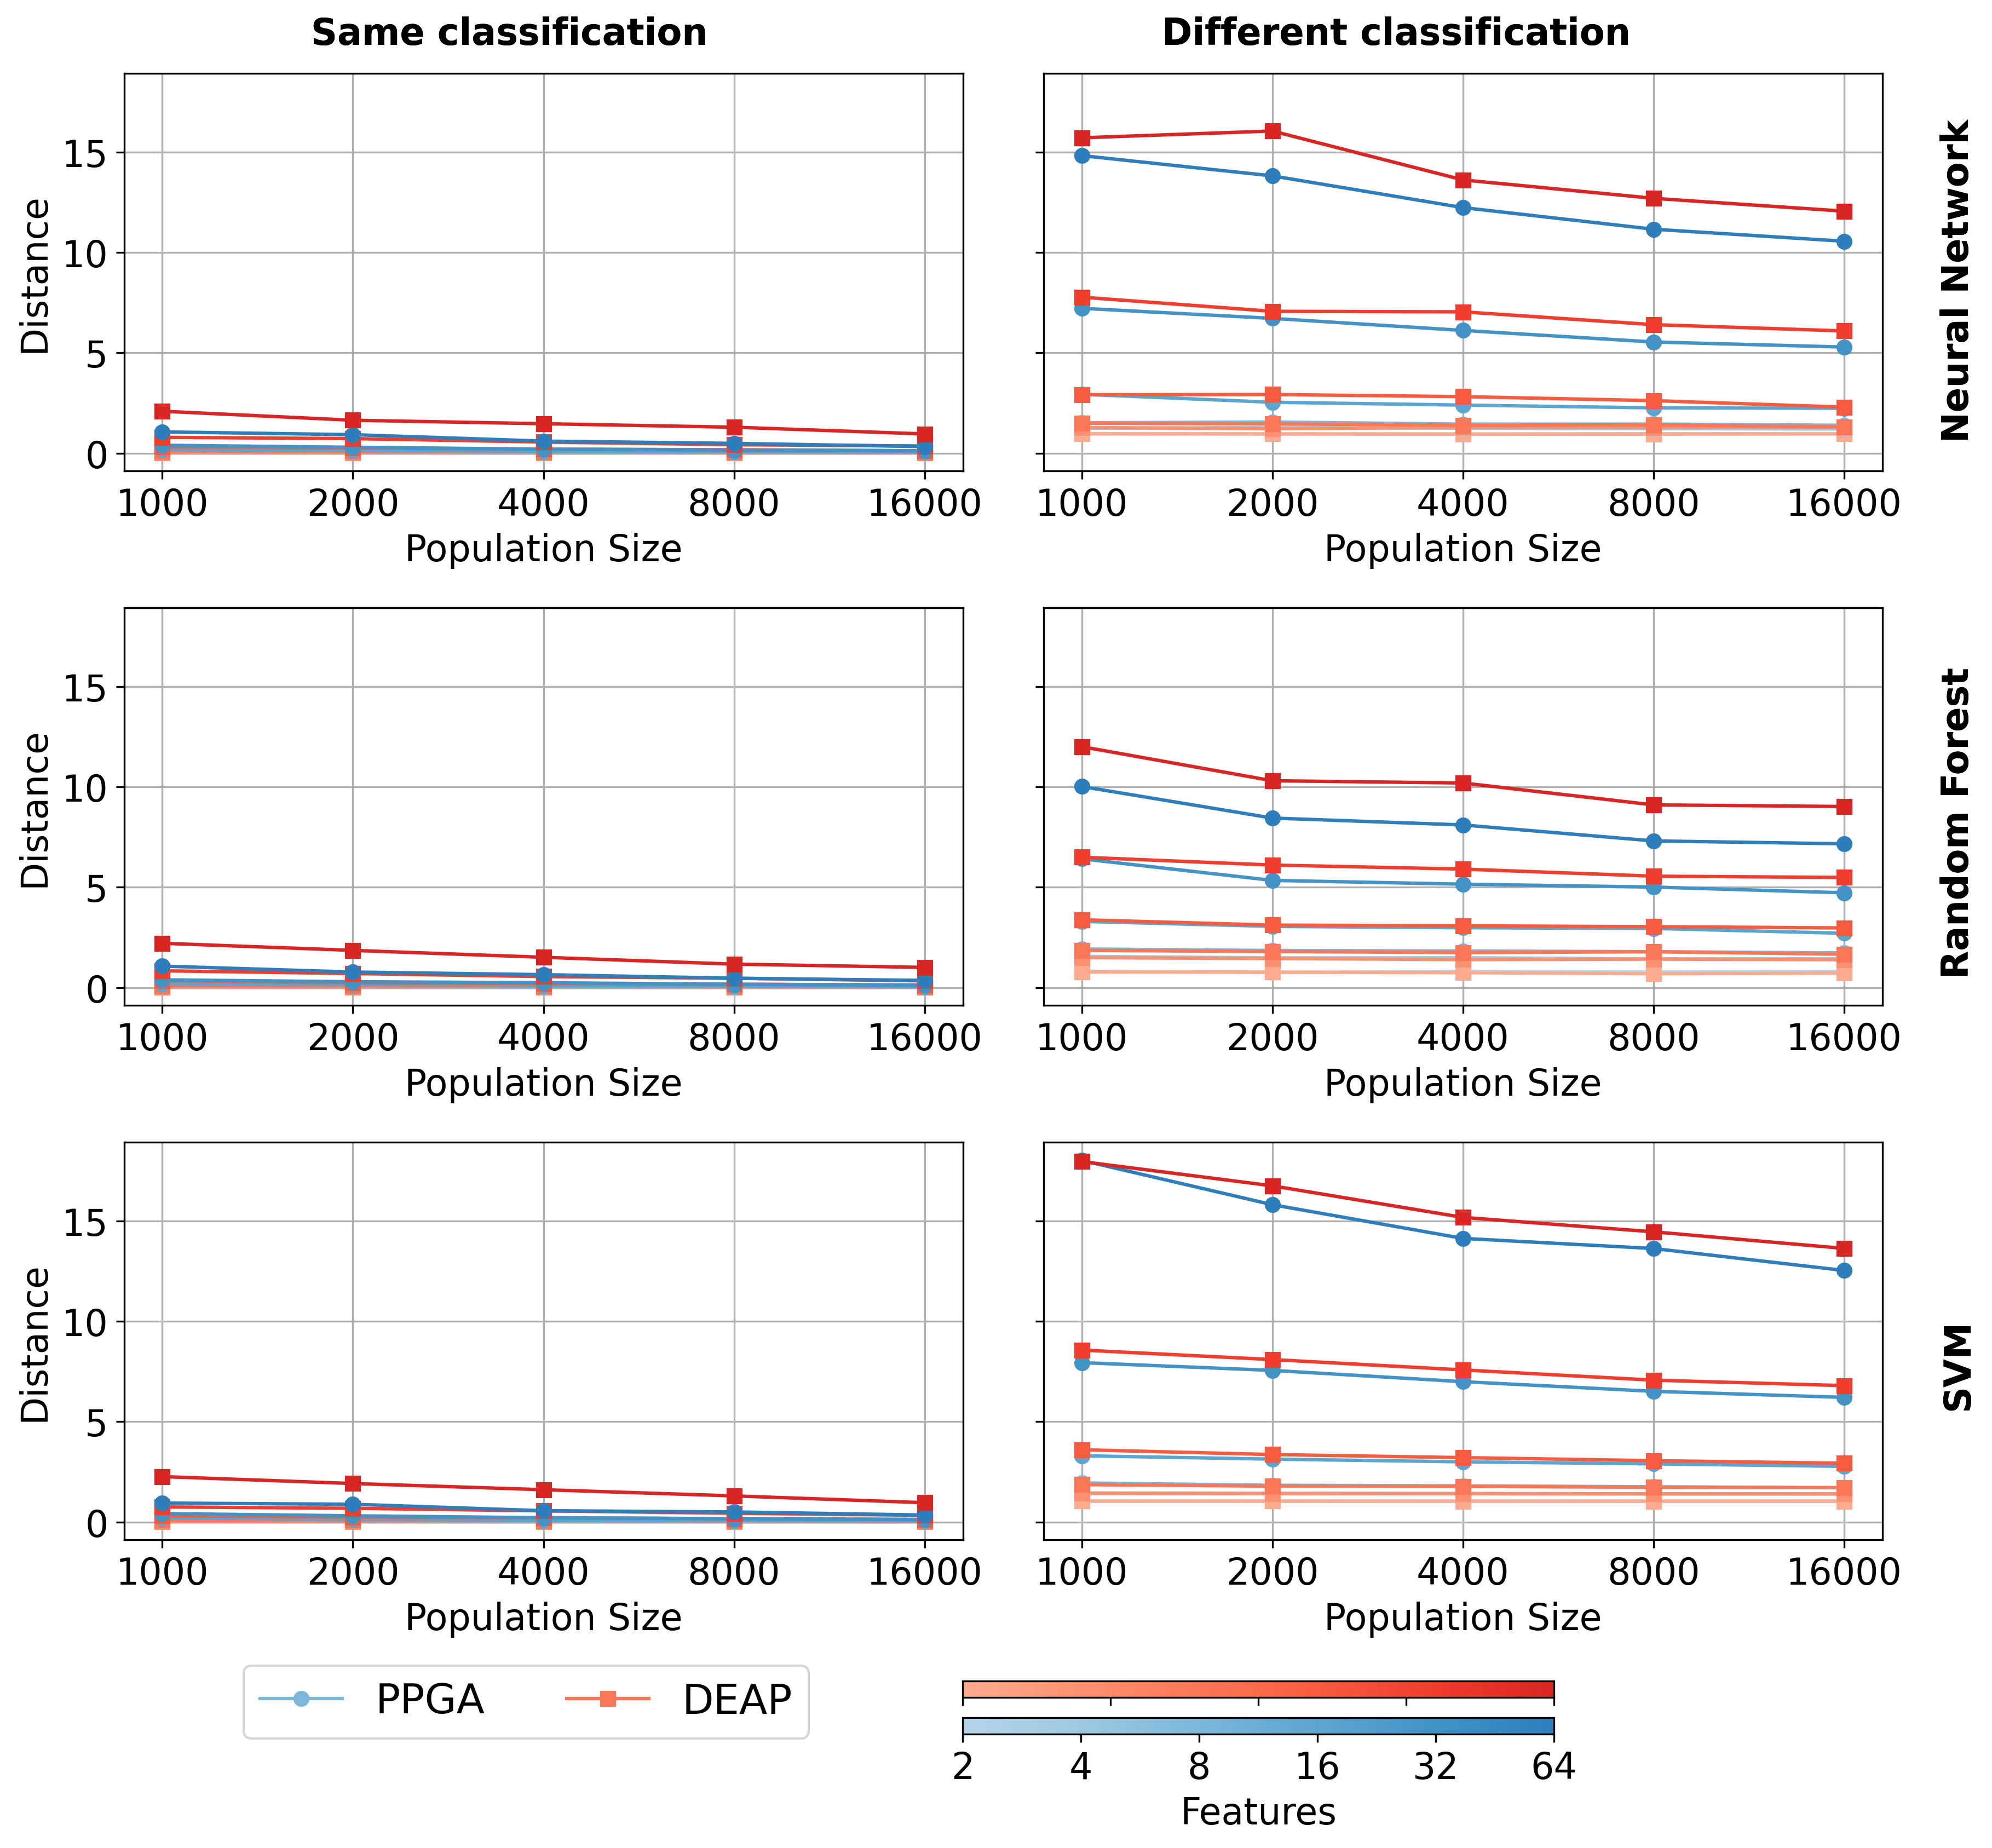

In [35]:
import operator
import matplotlib.colors as mcolors


def plot_mean_distance_popsize(df1: pd.DataFrame, df2: pd.DataFrame):
    models = df1["model"].unique()
    features = df1["features"].unique()
    # features = [16, 32, 64]

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(12, 10), dpi=300)
    ppga_color = plt.cm.Blues(np.linspace(0.3, 0.7, len(features)))
    deap_color = plt.cm.Reds(np.linspace(0.3, 0.7, len(features)))

    def plot_target(df1: pd.DataFrame, df2: pd.DataFrame, op):
        col = 0 if op is operator.eq else 1
        # target = "Same" if col == 0 else "Different"

        # PPGA
        temp_df1 = df1[op(df1["class"], df1["target"])]
        temp_df1 = (
            temp_df1.groupby(["model", "features", "population_size"])[
                ["mean_distance", "distance_std"]
            ]
            .mean()
            .reset_index()
        )

        # DEAP
        temp_df2 = df2[op(df2["class"], df2["target"])]
        temp_df2 = (
            temp_df2.groupby(["model", "features", "population_size"])[
                ["mean_distance", "distance_std"]
            ]
            .mean()
            .reset_index()
        )

        col_titles = ["Same classification", "Different classification"]
        for j, title in enumerate(col_titles):
            fig.text(
                0.27 + j * 0.45,
                1,
                title,
                ha="center",
                va="center",
                fontsize="16",
                fontweight="bold",
            )

        for i, model in enumerate(models):
            fig.text(
                1.005,
                0.85 - i * 0.33,
                ["Neural Network", "Random Forest", "SVM"][i],
                ha="center",
                va="center",
                fontsize=16,
                fontweight="bold",
                rotation=90,
            )
            for j, f in enumerate(features):
                # PPGA
                mask = (temp_df1["model"] == model) & (temp_df1["features"] == f)
                x = temp_df1[mask]["population_size"]
                y = temp_df1[mask]["mean_distance"]

                axes[i][col].plot(
                    x, y, color=ppga_color[j], marker="o", label=f"PPGA {f} features"
                )

                # DEAP
                mask = (temp_df2["model"] == model) & (temp_df2["features"] == f)
                x = temp_df2[mask]["population_size"]
                y = temp_df2[mask]["mean_distance"]

                axes[i][col].plot(
                    x, y, color=deap_color[j], marker="s", label=f"DEAP {f} features"
                )

                # tweaks
                # axes[i][col].set_title(
                #     f"{model} distance distribution\n{target} classification"
                # )
                axes[i][col].set_xlabel("Population Size")
                if col == 0:
                    axes[i][col].set_ylabel("Distance")
                axes[i][col].set_xscale("log", base=2)
                axes[i][col].set_xticks(
                    df1["population_size"].unique(),
                    labels=df1["population_size"].unique(),
                )
                axes[i][col].grid(True)
                # axes[i][col].legend()

    plot_target(df1, df2, operator.eq)
    plot_target(df1, df2, operator.ne)

    custom_legend = [
        Line2D([0], [0], color=ppga_color[2], marker="o", label="PPGA"),
        Line2D([0], [0], color=deap_color[2], marker="s", label="DEAP"),
    ]
    fig.legend(
        handles=custom_legend,
        loc="lower left",
        bbox_to_anchor=(0.125, -0.05),
        ncol=3,
        fontsize=18,
    )

    cmap = plt.cm.Reds
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Reds", cmap(np.linspace(0.3, 0.7, 256))
    )
    norm = mcolors.Normalize(0.3, 0.7)
    cbar_ax = fig.add_axes([0.5, -0.0125, 0.3, 0.01])  # [x, y, larghezza, altezza]
    cb = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticklabels([])

    cmap = plt.cm.Blues
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Blues", cmap(np.linspace(0.3, 0.7, 256))
    )
    cbar_ax = fig.add_axes([0.5, -0.035, 0.3, 0.01])  # [x, y, larghezza, altezza]
    cb = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticks(np.linspace(0.3, 0.7, 6))
    cb.set_ticklabels([2, 4, 8, 16, 32, 64])
    cb.set_label("Features")

    fig.tight_layout()
    fig.savefig("/home/federico/tesi/immagini/quality_pop.svg", bbox_inches="tight")
    plt.show()


plot_mean_distance_popsize(ppga_df, deap_df)

## Numero di feature variabile

In modo simile analizziamo l'andamento della distanza media al variare del
numero di feature.


/tmp/ipykernel_36238/1801627148.py:125: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


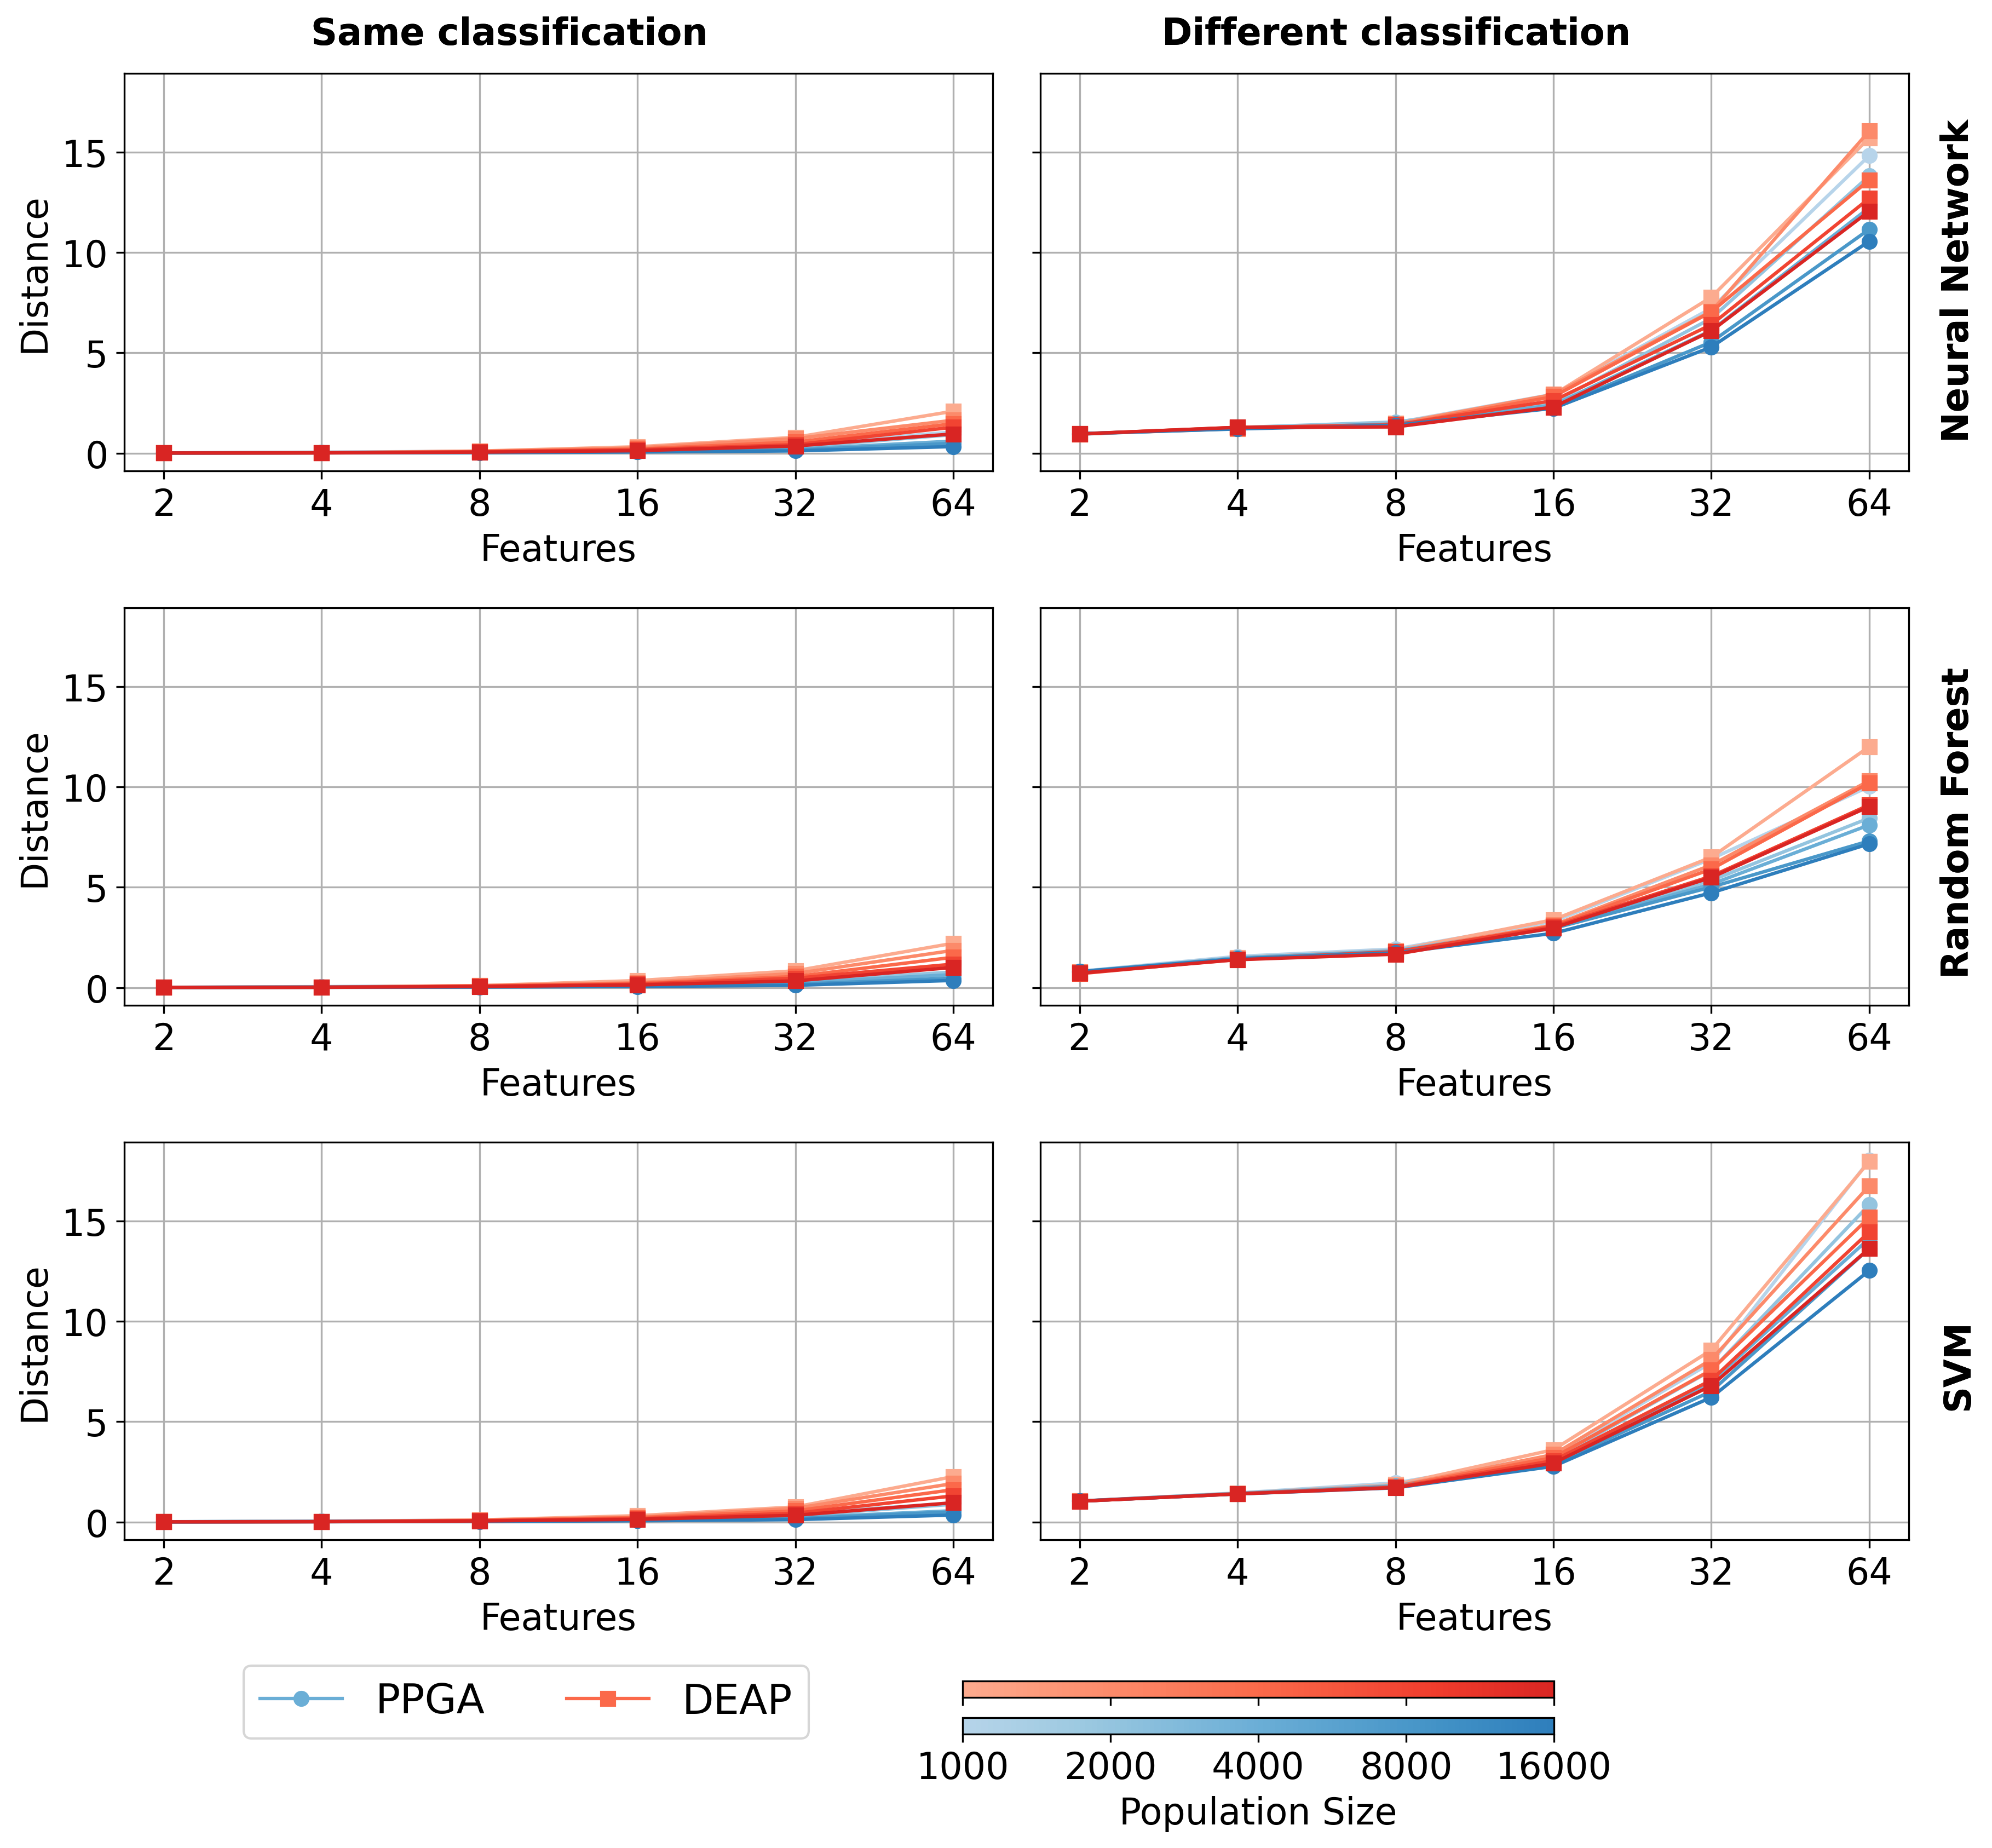

In [34]:
def plot_mean_distance_feature(df1: pd.DataFrame, df2: pd.DataFrame):
    models = df1["model"].unique()
    sizes = df1["population_size"].unique()
    # sizes = [4000, 8000, 16000]

    fig, axes = plt.subplots(len(models), 2, sharey=True, figsize=(12, 10), dpi=300)
    blues = plt.cm.Blues(np.linspace(0.3, 0.7, len(sizes)))
    reds = plt.cm.Reds(np.linspace(0.3, 0.7, len(sizes)))

    def plot_target(df1: pd.DataFrame, df2: pd.DataFrame, op):
        col = 0 if op is operator.eq else 1

        temp_df1 = df1[op(df1["class"], df1["target"])]
        temp_df1 = (
            temp_df1.groupby(["model", "features", "population_size"])["mean_distance"]
            .mean()
            .reset_index()
        )
        temp_df2 = df2[op(df2["class"], df2["target"])]
        temp_df2 = (
            temp_df2.groupby(["model", "features", "population_size"])["mean_distance"]
            .mean()
            .reset_index()
        )

        col_titles = ["Same classification", "Different classification"]
        for j, title in enumerate(col_titles):
            fig.text(
                0.27 + j * 0.45,
                1,
                title,
                ha="center",
                va="center",
                fontsize="16",
                fontweight="bold",
            )

        for i, model in enumerate(models):
            fig.text(
                1.005,
                0.85 - i * 0.33,
                ["Neural Network", "Random Forest", "SVM"][i],
                ha="center",
                va="center",
                fontsize=16,
                fontweight="bold",
                rotation=90,
            )
            for j, s in enumerate(sizes):
                # axes[i][col].set_title(
                #     f"{model} distance trend on feature number variations\n{target} classification"
                # )
                axes[i][col].set_xlabel("Features")
                if col == 0:
                    axes[i][col].set_ylabel("Distance")

                # PPGA curves
                mask = (temp_df1["model"] == model) & (temp_df1["population_size"] == s)
                x = temp_df1[mask]["features"]
                y = temp_df1[mask]["mean_distance"]
                axes[i][col].plot(
                    x, y, color=blues[j], marker="o", label=f"PPGA {s} individuals"
                )

                # DEAP curves
                mask = (temp_df2["model"] == model) & (temp_df2["population_size"] == s)
                x = temp_df2[mask]["features"]
                y = temp_df2[mask]["mean_distance"]
                axes[i][col].plot(
                    x, y, color=reds[j], marker="s", label=f"DEAP {s} individuals"
                )

                # tweaks
                axes[i][col].set_xscale("log", base=2)
                axes[i][col].set_xticks(
                    df1["features"].unique(), labels=df1["features"].unique()
                )

                axes[i][col].grid(True)
                # axes[i][col].legend()

    plot_target(df1, df2, operator.eq)
    plot_target(df1, df2, operator.ne)

    custom_legend = [
        Line2D([0], [0], color=blues[2], marker="o", label="PPGA"),
        Line2D([0], [0], color=reds[2], marker="s", label="DEAP"),
    ]

    fig.legend(
        handles=custom_legend,
        loc="lower left",
        bbox_to_anchor=(0.125, -0.05),
        ncol=3,
        fontsize=18,
    )

    cmap = plt.cm.Reds
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Reds", cmap(np.linspace(0.3, 0.7, 256))
    )
    norm = mcolors.Normalize(0.3, 0.7)
    cbar_ax = fig.add_axes([0.5, -0.0125, 0.3, 0.01])  # [x, y, larghezza, altezza]
    cb = fig.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticklabels([])

    cmap = plt.cm.Blues
    cmap = mcolors.LinearSegmentedColormap.from_list(
        "truncated_Blues", cmap(np.linspace(0.3, 0.7, 256))
    )
    cbar_ax = fig.add_axes([0.5, -0.035, 0.3, 0.01])  # [x, y, larghezza, altezza]
    cb = plt.colorbar(
        plt.cm.ScalarMappable(norm=norm, cmap=cmap),
        cax=cbar_ax,
        orientation="horizontal",
    )
    cb.set_ticks(np.linspace(0.3, 0.7, 5))
    cb.set_ticklabels([1000, 2000, 4000, 8000, 16000])
    cb.set_label("Population Size")

    plt.tight_layout()
    plt.savefig("/home/federico/tesi/immagini/quality_feature.svg", bbox_inches="tight")
    plt.show()


plot_mean_distance_feature(ppga_df, deap_df)

# Parallelismo e qualità delle soluzioni

Prima di concludere si vuole evidenziare alcune possibili criticità quando si
lavora con la versione parallela della libreria. A differenza di DEAP, che
parallelizza solo la fase di valutazione, questa parallelizza anche le fasi di
crossover, mutazione.

Durante la fase di test sono infatti emerse alcune criticità riguardanti tali
operatori, che in contesto di calcolo parallelo potrebbero portare a
comportamenti inattesi.

## Crossover

Dato che la genereazione della popolazione iniziale avviene per copia, la
diversità genetica iniziale è pari a zero. Per un algoritmo genetico, questo
è in generale un problema dato che sfrutta meccanismi come il crossover per
ricombinare i cromosomi tra individui diversi.

Nel nostro caso partiamo però da una situazione in cui tutti gli individui sono
cloni e utilizziamo metodi di crossover come quello a singolo o doppio punto di
crossover, che non producono nuovi valori per le feature ma si limitano ad
esplorare e ricombinare quelli già esistenti. Ne segue che l'applicazione del
crossover tra due cloni risulterà nella generazione di altri due cloni identici
tra di loro e ai loro genitori.

## Mutazione

Per le prime iterazioni ci si affida quindi all'operatore di mutazione come
unico meccanismo per introdurre diversità genetica. Il problema è che la
mutazione ha generalmente una probabilità bassa di essere applicata (in genere
20/30%). Se aggiungiamo poi che ogni feature ha una probabilità indipendente di
essere modificata, la probabilità che un individuo scelto per la mutazione,
venga effettivamente modificato, cala ulteriormente. Quando partizioniamo la
popolazione tra molti worker si potrebbe andare incontro ad un problema nel
caso in cui il rapporto

$$\frac{N}{W}$$

dove $N$ è il numero di individui e $W$ è il numero di worker, è troppo basso.
Si rischia che i worker mutino pochi individui o nessuno, lasciando la
diversità genetica bassa per diverse iterazioni.

Per evitare che ciò accada è necessario che la probabilità indipendente sia
abbastanza alta, ma soprattutto che il numero di individui assegnato ad ogni
worker sia sufficientemente elevato.

## Seme di casualità

Dato che le fasi di crossover e mutazione fanno leva sulla generazione di
numeri casuali, è necessario fare alcune considerazioni. Il **seme** di
casualità deve essere inizializzato per ogni worker in modo da essere sicuri
che sia diverso. Se non inizializzato esplicitamente verrà usata la funzione
`time.time()`, la quale ha una risoluzione dell'ordine dei secondi.

Ne seguirebbe che ogni worker è inizializzato quasi sicuramente con lo stesso
seed e quindi muta gli stessi individui allo stesso modo degli altri worker.
Andiamo quindi a creare $W$ sottopopolazioni tutte identiche tra di loro.

La libreria inizializza i generatori di numeri casuali sia del modulo `random`
di Python, sia di `numpy` sulla base dell'ID di ognuno dei worker.
